In [366]:
import lxml.etree as et
import numpy as np
import pandas as pd
from IPython.display import SVG, display

In [367]:
%load_ext autoreload
%autoreload 1
%aimport adastra

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [368]:
fa17missing = [
    ('OIE1000', 5/3),  # OIE
    ('AHSE1148', 10/3),  # DIRT TO SHIRT
    ('ENGR3590', 3),  # ADE
    ('AHSE1100', 10/3),  # HISTECH
    ('ENGR3299', 8),  # RETURN DESIGN
]
sp18missing = [
    ('ENGR3590', 10/3),  # CompRobo
    ('ENGR3240', 16/3),  # TELL THE STORY
    ('MTH2132', 10/3),  # BAYESIAN
    ('ENGR3299', 10/3),  # BIOMIMICRY
    ('ENGR3599A', 10/3),  # HTL
    ('ENGR3299B', 8),  # RETURN DESIGN
]
tup_to_dict = lambda a: [{'Course/Customer': code, 'Weekly Length': pd.to_timedelta(hours, unit='h')} for code, hours in a]
fa17missing, sp18missing = tuple(tup_to_dict(l) for l in [fa17missing, sp18missing])

In [369]:
fa17courses = adastra.load_schedule_file('data/ad astra test fa17.xls')
sp18courses = adastra.load_schedule_file('data/ad astra test sp18.xls')

WARNING *** file size (190919) not 512 + multiple of sector size (512)
WARNING *** file size (222207) not 512 + multiple of sector size (512)


In [370]:
add_missing = lambda a, m: pd.concat([a, pd.DataFrame(m)], sort=True, ignore_index=False).reset_index()
fa17courses = add_missing(fa17courses, fa17missing)
sp18courses = add_missing(sp18courses, sp18missing)

In [371]:
fa17cat = pd.read_csv('Class and Room Categorization - Classes Fall 2017.csv', usecols=range(13))
fa17cat.drop_duplicates(subset='Course Code', inplace=True)
sp18cat = pd.read_csv('Class and Room Categorization - Classes Spring 2018.csv', usecols=range(13))
sp18cat.drop_duplicates(subset='Course Code', inplace=True)

In [372]:
def strip(text):
    try:
        return text.strip()
    except AttributeError:
        return text

def to_int(text):
    return int(text.strip('" '))

def getEnrollment(filename):
    enrollment = pd.read_csv(
        filename,
        usecols=[2,9],
        converters = {'Crs No' : strip, 'Registered Students' : to_int})
    enrollment.drop_duplicates(subset='Crs No', inplace=True)
    return enrollment

In [373]:
fa17enrollment = getEnrollment('FA17_Enrollment.csv')
sp18enrollment = getEnrollment('SP18_Enrollment.csv')

In [374]:
def merge(sched, enrollment, sched_code='Course/Customer', en_code='Crs No'):

#     def agg_time(frame, group_col, agg_col):
#         return frame.groupby(group_col, as_index=False)[agg_col].agg(np.sum)

    merge1 = pd.merge(
        left=sched,
        right=enrollment,
        how='inner',
        left_on=sched_code,
        right_on=en_code,
        indicator=True,
#         validate='one_to_many'
    )
    
    return merge1

agg_by_time = lambda a: a.groupby('Course/Customer', as_index=False)['Weekly Length'].agg(np.sum)
agg_by_room = lambda a: a.groupby('Room', as_index=False)['Weekly Length'].agg(np.sum)

In [395]:
#fa17footprint, sp18footprint = tuple(merge(agg_by_time(sched), enrollment) for sched, enrollment in [(fa17courses, fa17enrollment),(sp18courses, sp18enrollment)])
fa17footprint, sp18footprint = tuple(merge(sched, enrollment) for sched, enrollment in [(fa17courses, fa17enrollment),(sp18courses, sp18enrollment)])
fa17_room_usage = agg_by_room(fa17footprint)
fa17_room_usage.sort_values('Weekly Length', inplace=True)
sp18_room_usage = agg_by_room(sp18footprint)
sp18_room_usage.sort_values('Weekly Length', inplace=True)

print(fa17_room_usage)
print(sp18_room_usage)

   Room Weekly Length
1   109      03:20:00
0   104      04:00:00
9   305      05:35:00
12  313      06:40:00
11  309      06:40:00
10  306      06:40:00
2   113      07:00:00
20  428      08:40:00
3   128      10:00:00
6   209      10:20:00
4   204      10:20:00
5   206      10:20:00
18  413      10:40:00
19  417      11:00:00
7   213      12:20:00
16  406      12:20:00
17  409      13:00:00
15  328      13:20:00
8   304      17:15:00
13  318      20:25:00
14  326      22:30:00
   Room   Weekly Length
0   104 0 days 04:00:00
14  406 0 days 05:20:00
6   209 0 days 05:20:00
5   206 0 days 05:20:00
4   204 0 days 05:20:00
8   304 0 days 06:40:00
2   113 0 days 07:00:00
3   128 0 days 09:10:00
17  428 0 days 09:40:00
10  309 0 days 10:10:00
7   213 0 days 10:30:00
9   306 0 days 10:30:00
15  413 0 days 10:40:00
1   109 0 days 13:40:00
12  326 0 days 17:00:00
11  318 0 days 20:55:00
16  417 0 days 21:10:00
13  328 1 days 01:15:00


In [392]:
filenames = ['1stFloorPoly','2ndFloorPoly', '3rdFloorPoly', '4thFloorPoly']

In [393]:
def getPolygonCenter(pts):
    xMax = np.max(pts[:,0])
    xMin = np.min(pts[:,0])
    xC = (xMax - xMin)/2 + xMin
    
    yMax = np.max(pts[:,1])
    yMin = np.min(pts[:,1])
    yC = (yMax - yMin)/2 + yMin
    
    return(np.array([xC, yC]))

def getRecenterString(center, scale):
    c = (1 - scale) * center
    return 'translate(' + str(c[0]) + ', ' + str(c[1]) + ')'

def rescale(data, min, max):
    n = data.max() - data.min()
    return ((data - data.min())/n)*(max - min) + min

{'109': 0.05, '104': 0.11782608695652173, '305': 0.2789130434782608, '313': 0.38913043478260867, '309': 0.38913043478260867, '306': 0.38913043478260867, '113': 0.4230434782608695, '428': 0.5926086956521739, '128': 0.7282608695652173, '209': 0.7621739130434783, '204': 0.7621739130434783, '206': 0.7621739130434783, '413': 0.796086956521739, '417': 0.83, '213': 0.9656521739130434, '406': 0.9656521739130434, '409': 1.0334782608695652, '328': 1.067391304347826, '304': 1.4658695652173912, '318': 1.7880434782608696, '326': 2.0}


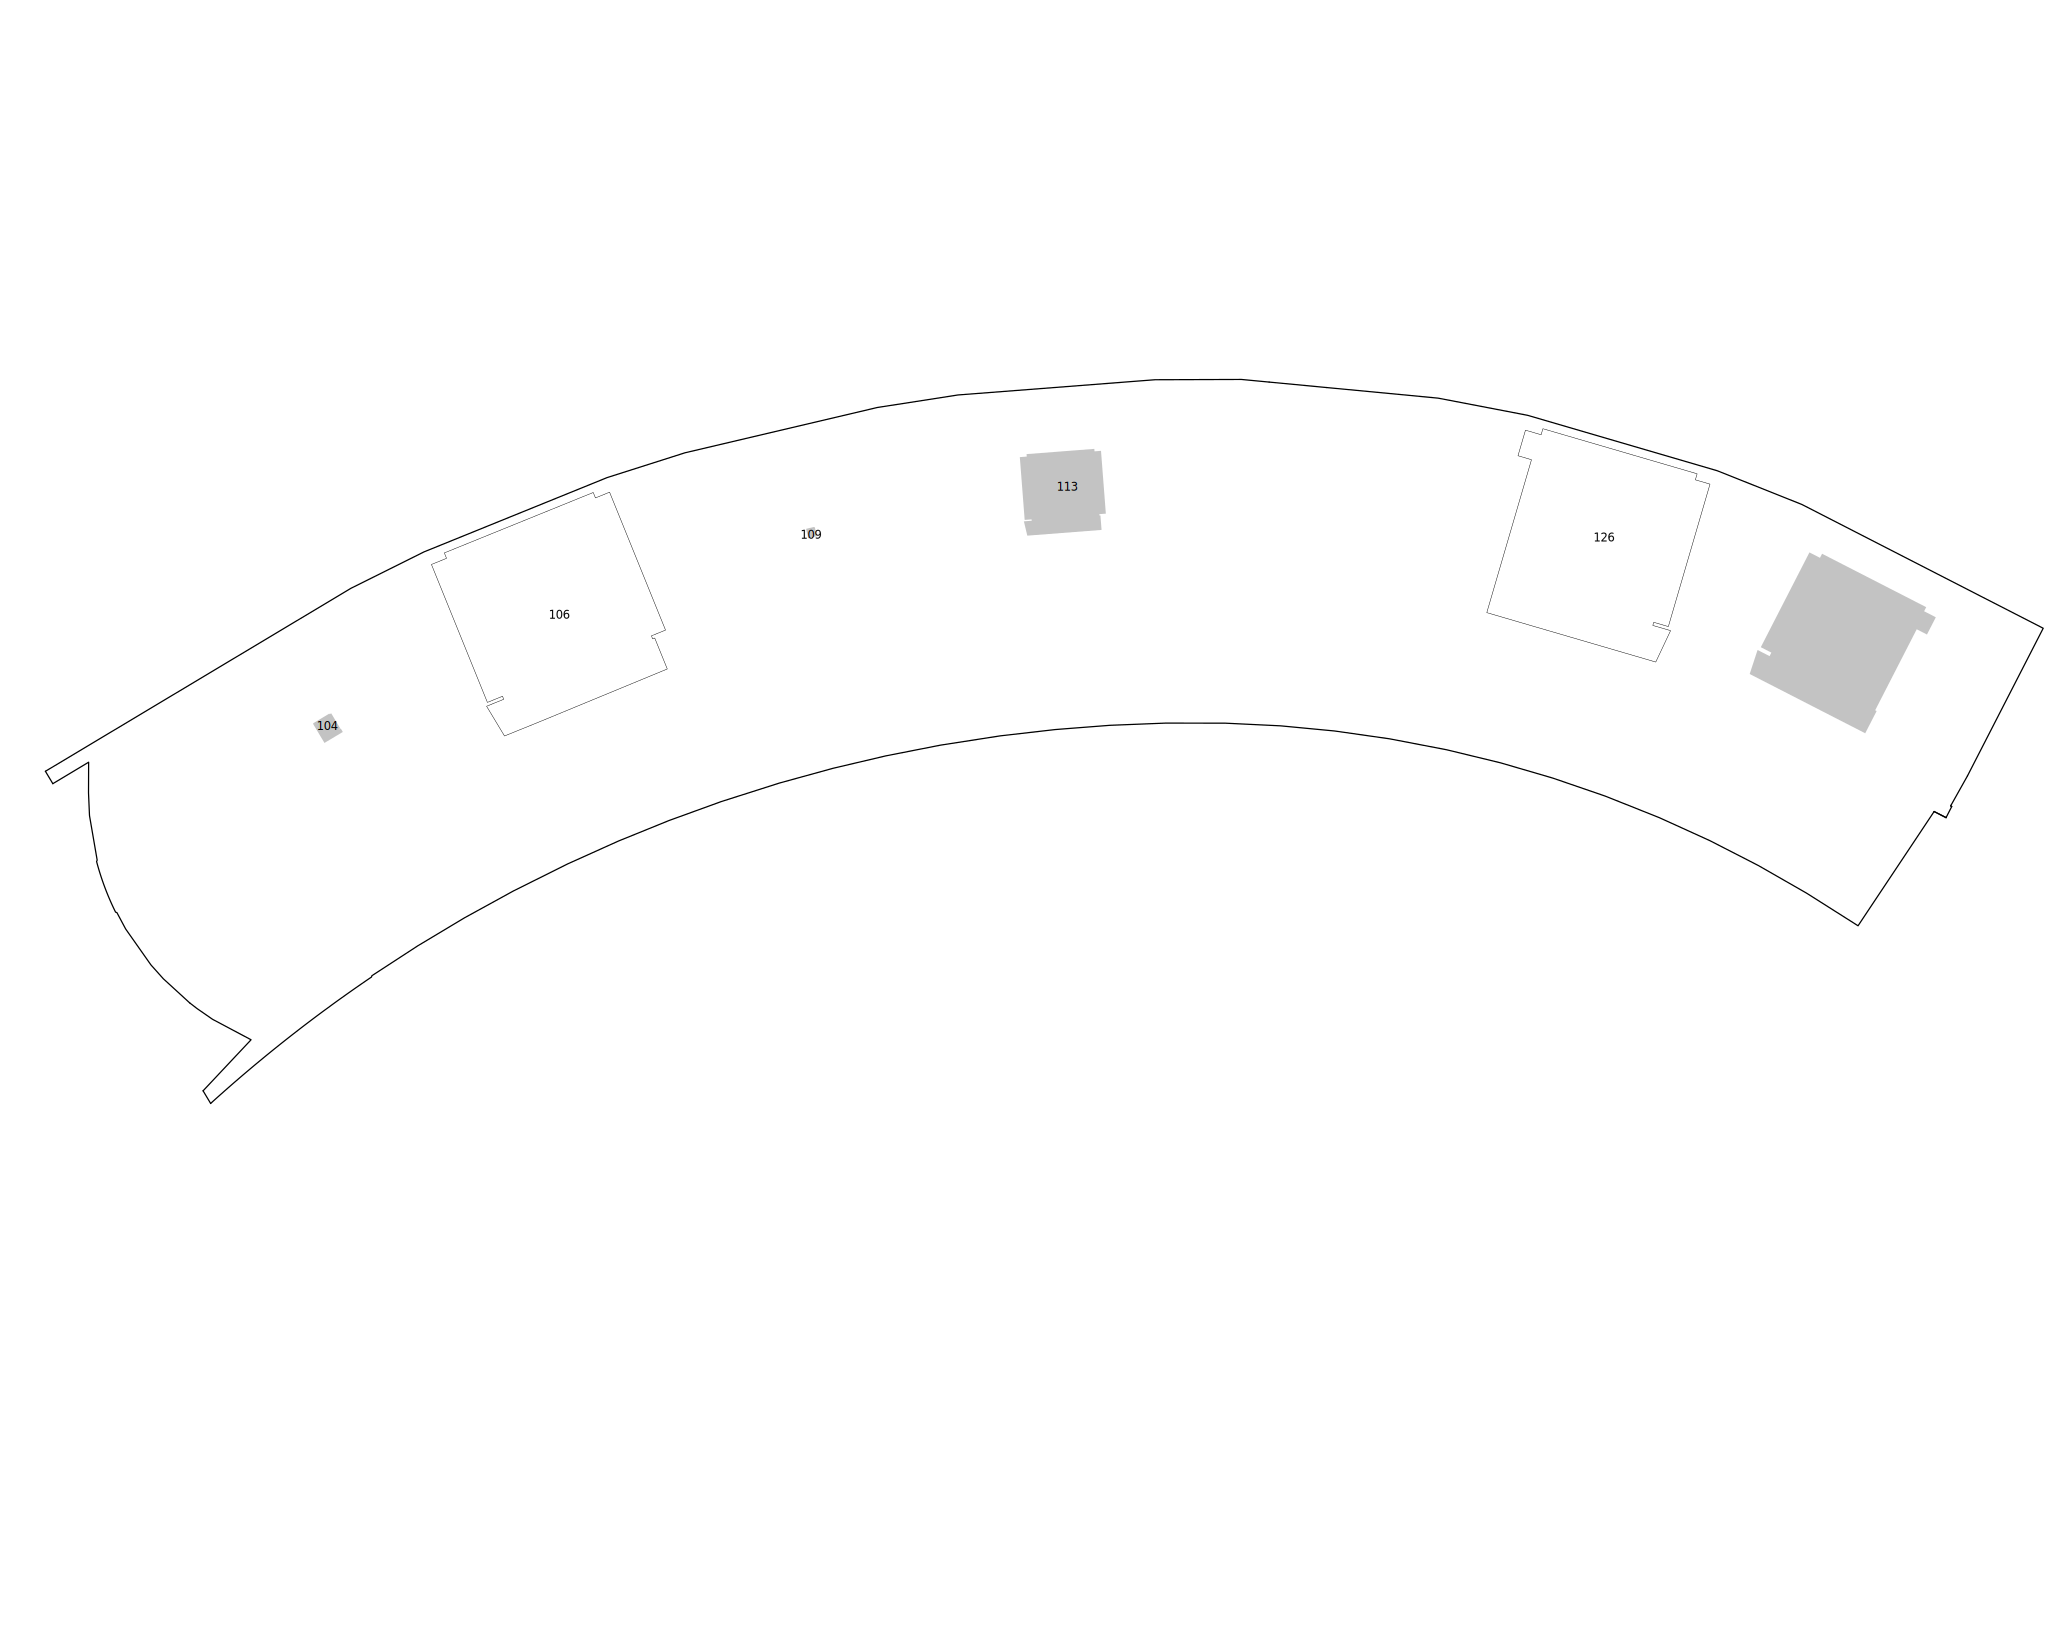

{'109': 0.05, '104': 0.11782608695652173, '305': 0.2789130434782608, '313': 0.38913043478260867, '309': 0.38913043478260867, '306': 0.38913043478260867, '113': 0.4230434782608695, '428': 0.5926086956521739, '128': 0.7282608695652173, '209': 0.7621739130434783, '204': 0.7621739130434783, '206': 0.7621739130434783, '413': 0.796086956521739, '417': 0.83, '213': 0.9656521739130434, '406': 0.9656521739130434, '409': 1.0334782608695652, '328': 1.067391304347826, '304': 1.4658695652173912, '318': 1.7880434782608696, '326': 2.0}


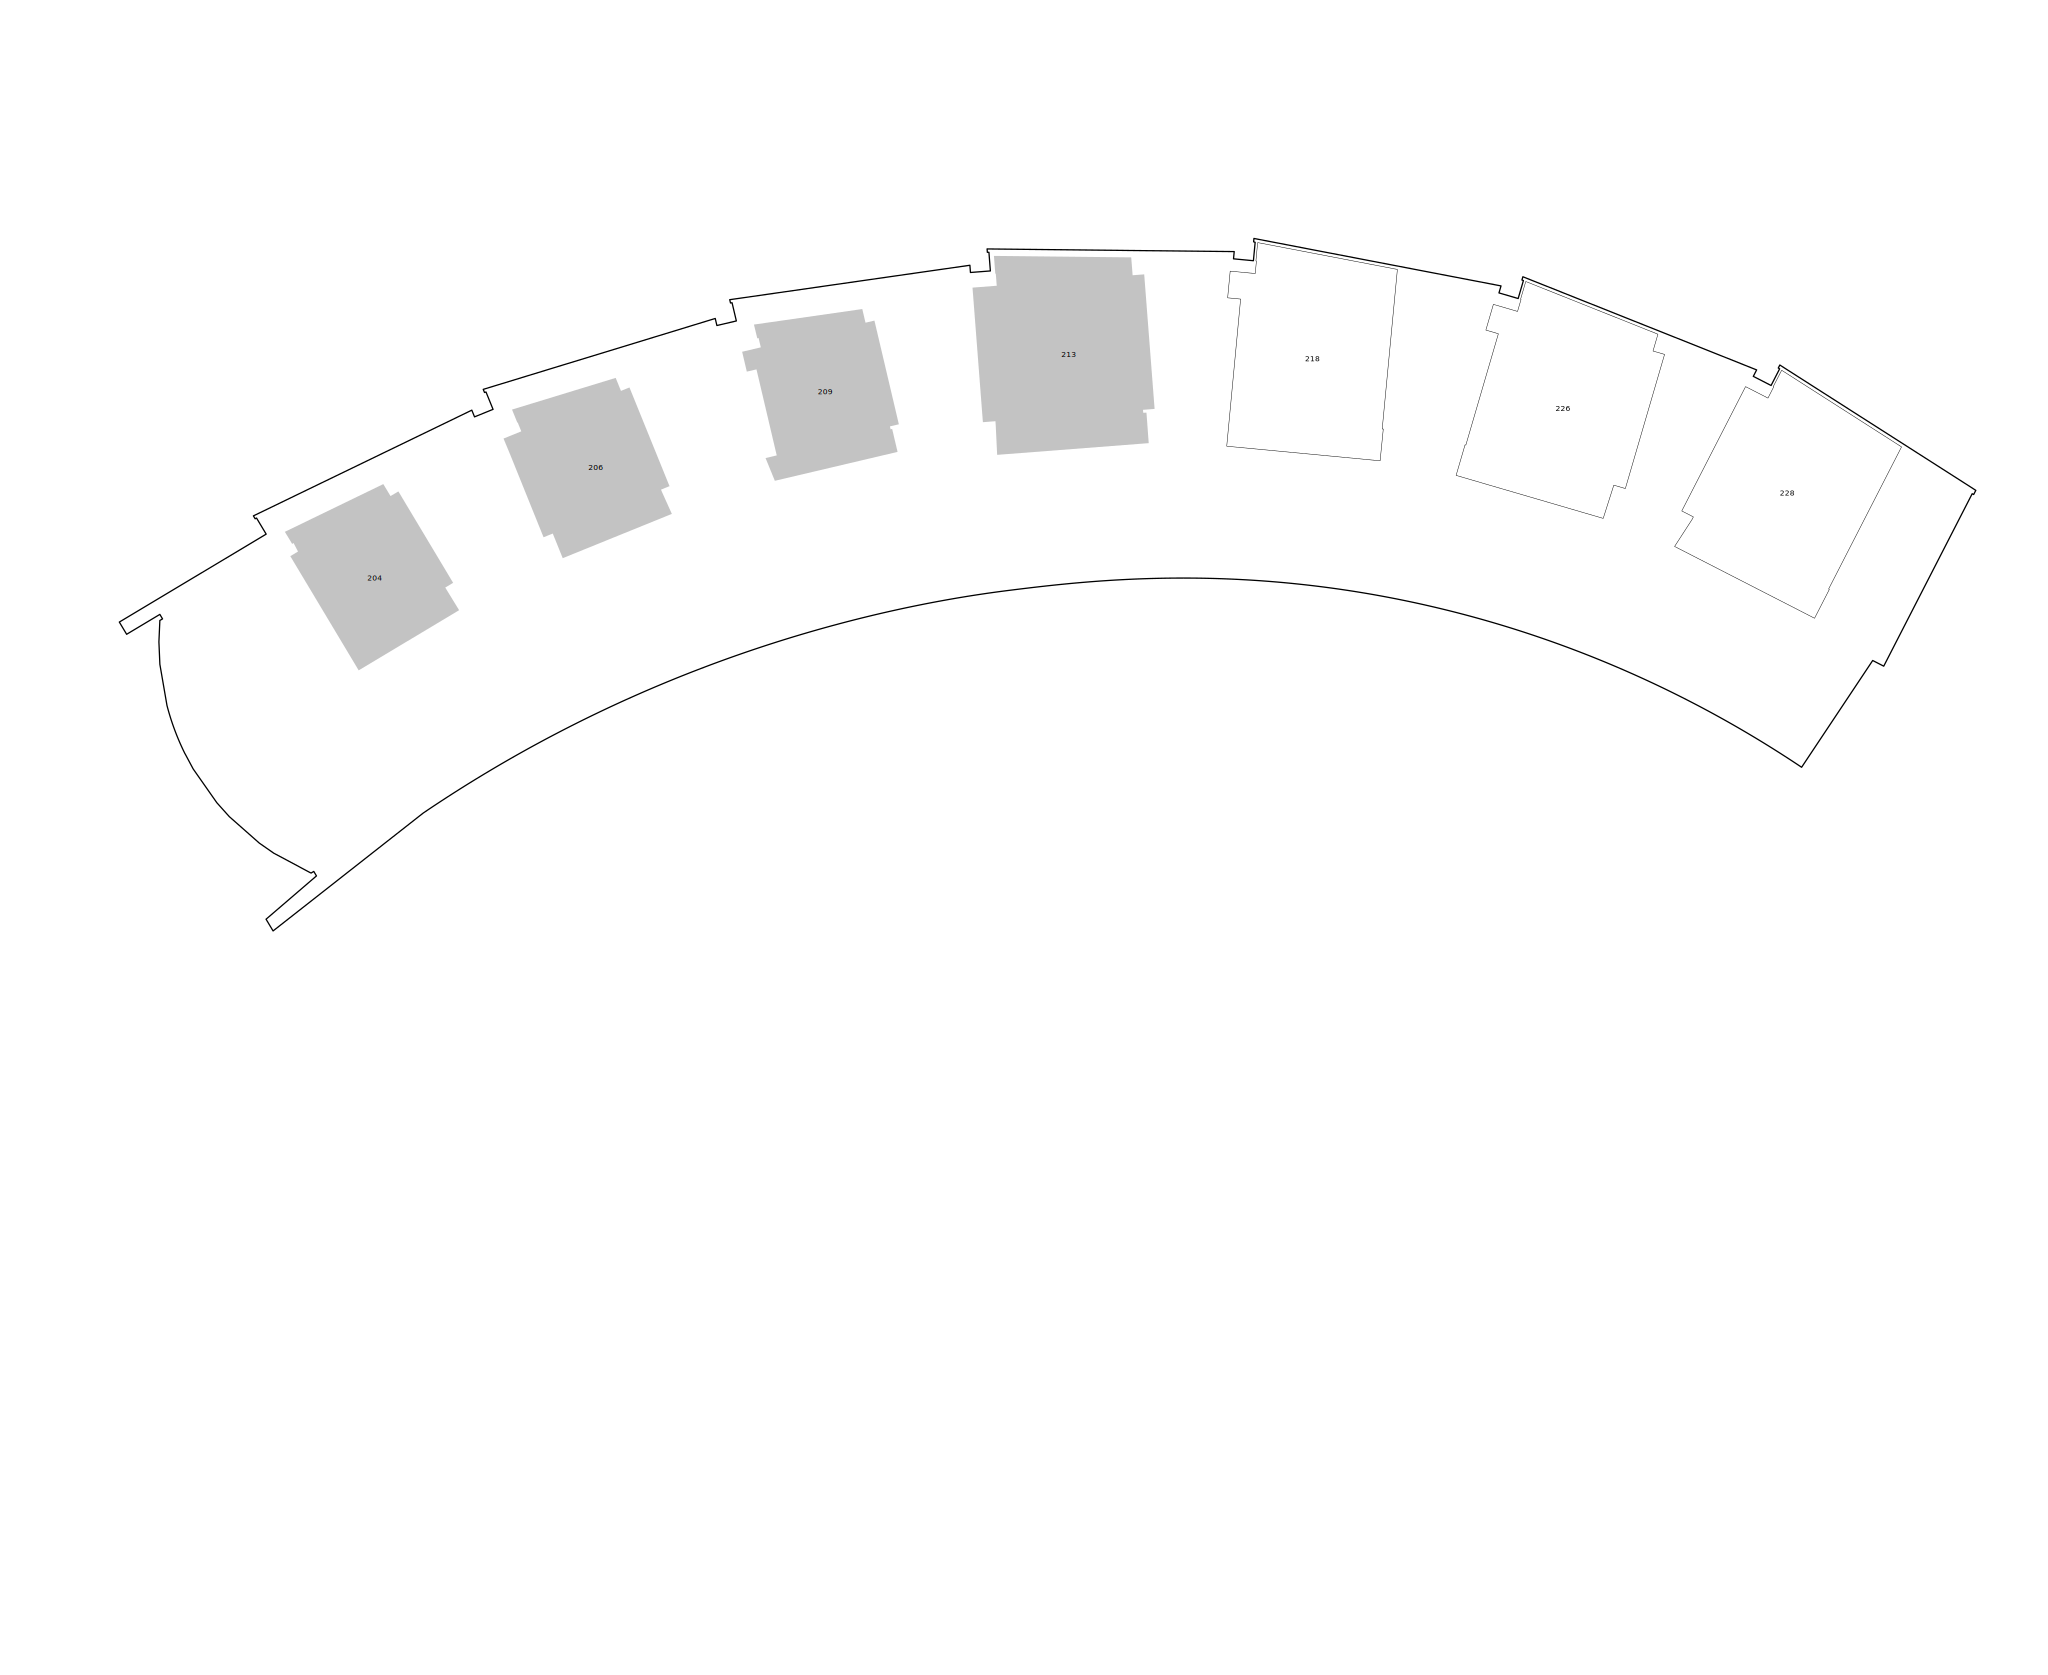

{'109': 0.05, '104': 0.11782608695652173, '305': 0.2789130434782608, '313': 0.38913043478260867, '309': 0.38913043478260867, '306': 0.38913043478260867, '113': 0.4230434782608695, '428': 0.5926086956521739, '128': 0.7282608695652173, '209': 0.7621739130434783, '204': 0.7621739130434783, '206': 0.7621739130434783, '413': 0.796086956521739, '417': 0.83, '213': 0.9656521739130434, '406': 0.9656521739130434, '409': 1.0334782608695652, '328': 1.067391304347826, '304': 1.4658695652173912, '318': 1.7880434782608696, '326': 2.0}


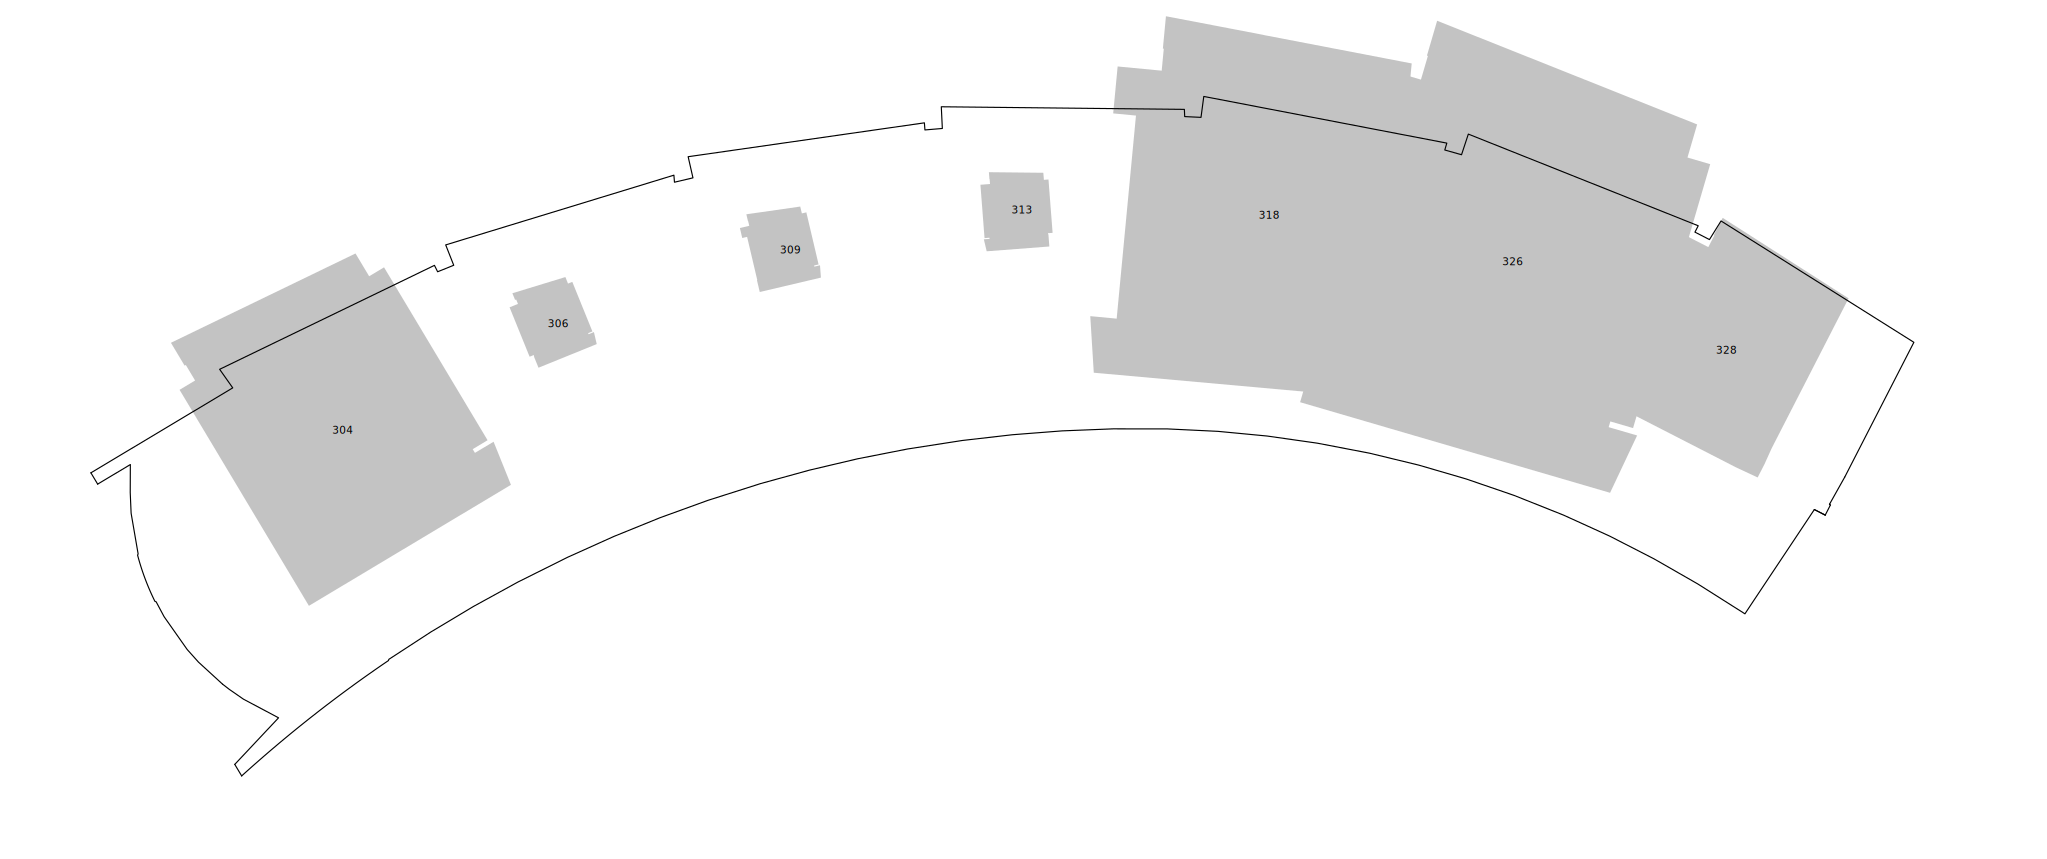

{'109': 0.05, '104': 0.11782608695652173, '305': 0.2789130434782608, '313': 0.38913043478260867, '309': 0.38913043478260867, '306': 0.38913043478260867, '113': 0.4230434782608695, '428': 0.5926086956521739, '128': 0.7282608695652173, '209': 0.7621739130434783, '204': 0.7621739130434783, '206': 0.7621739130434783, '413': 0.796086956521739, '417': 0.83, '213': 0.9656521739130434, '406': 0.9656521739130434, '409': 1.0334782608695652, '328': 1.067391304347826, '304': 1.4658695652173912, '318': 1.7880434782608696, '326': 2.0}


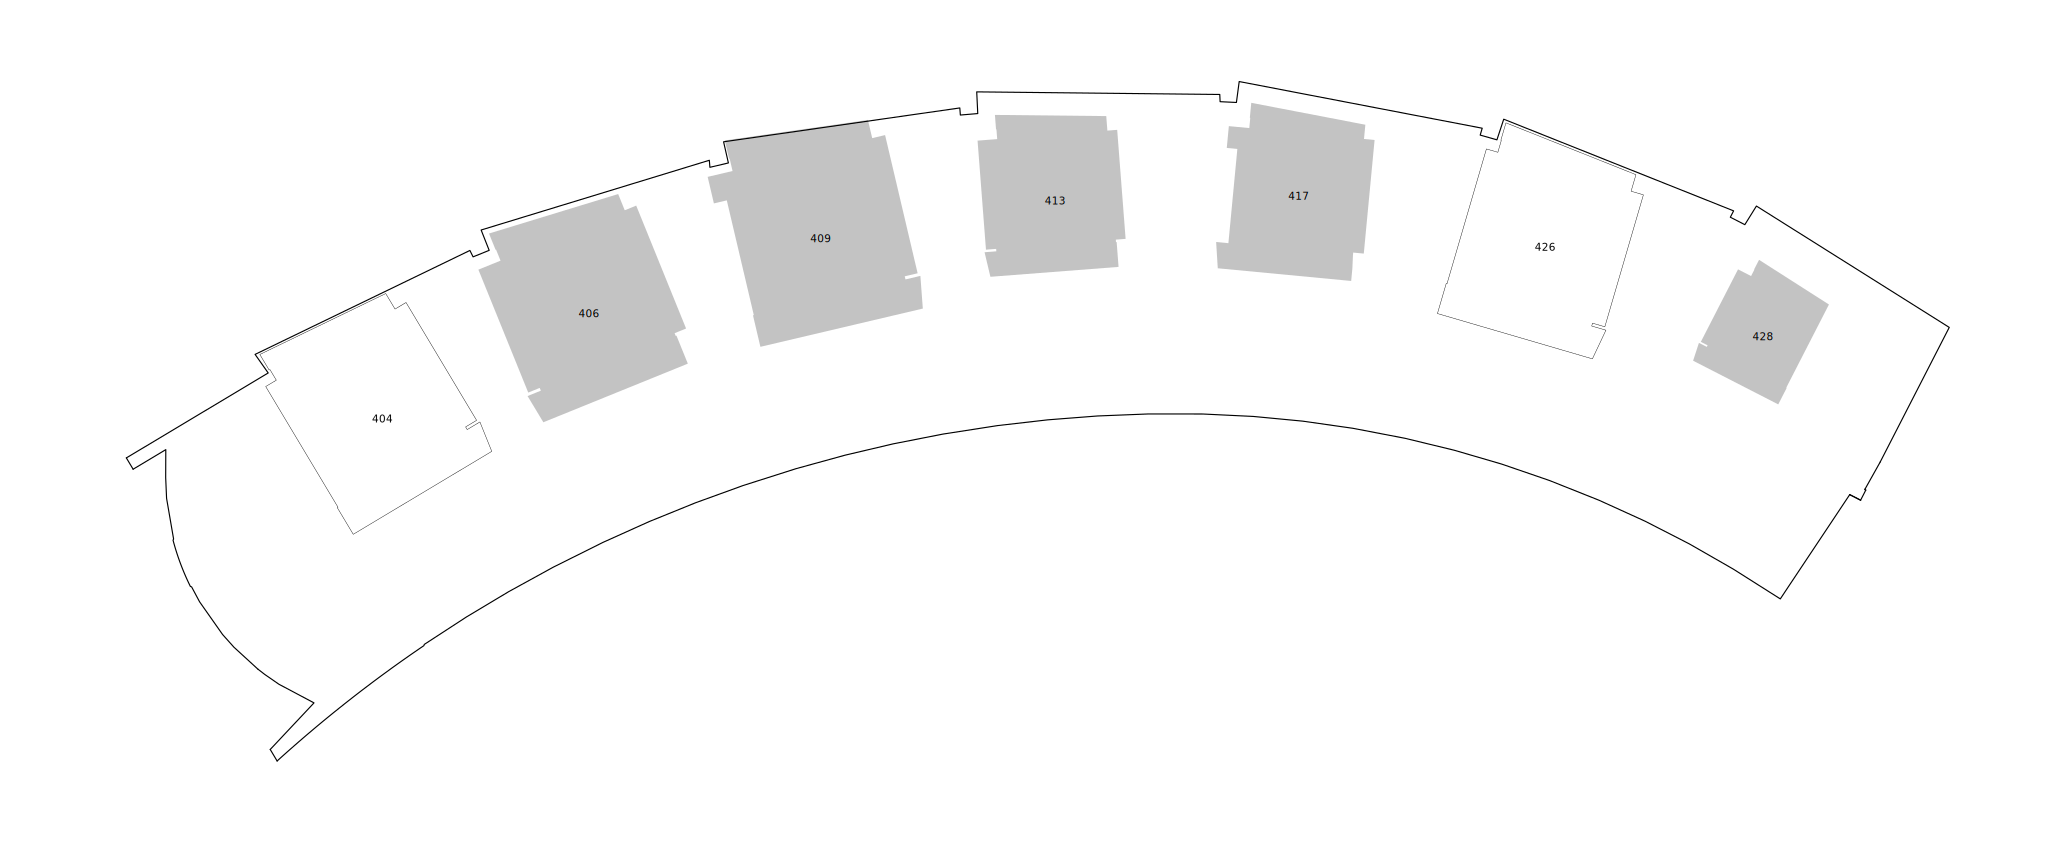

{'104': 0.05, '406': 0.17235294117647054, '209': 0.17235294117647054, '206': 0.17235294117647054, '204': 0.17235294117647054, '304': 0.2947058823529412, '113': 0.3252941176470588, '128': 0.5241176470588235, '428': 0.5700000000000001, '309': 0.6158823529411764, '213': 0.6464705882352942, '306': 0.6464705882352942, '413': 0.6617647058823529, '109': 0.9370588235294117, '326': 1.2429411764705884, '318': 1.6023529411764708, '417': 1.6252941176470588, '328': 2.0}


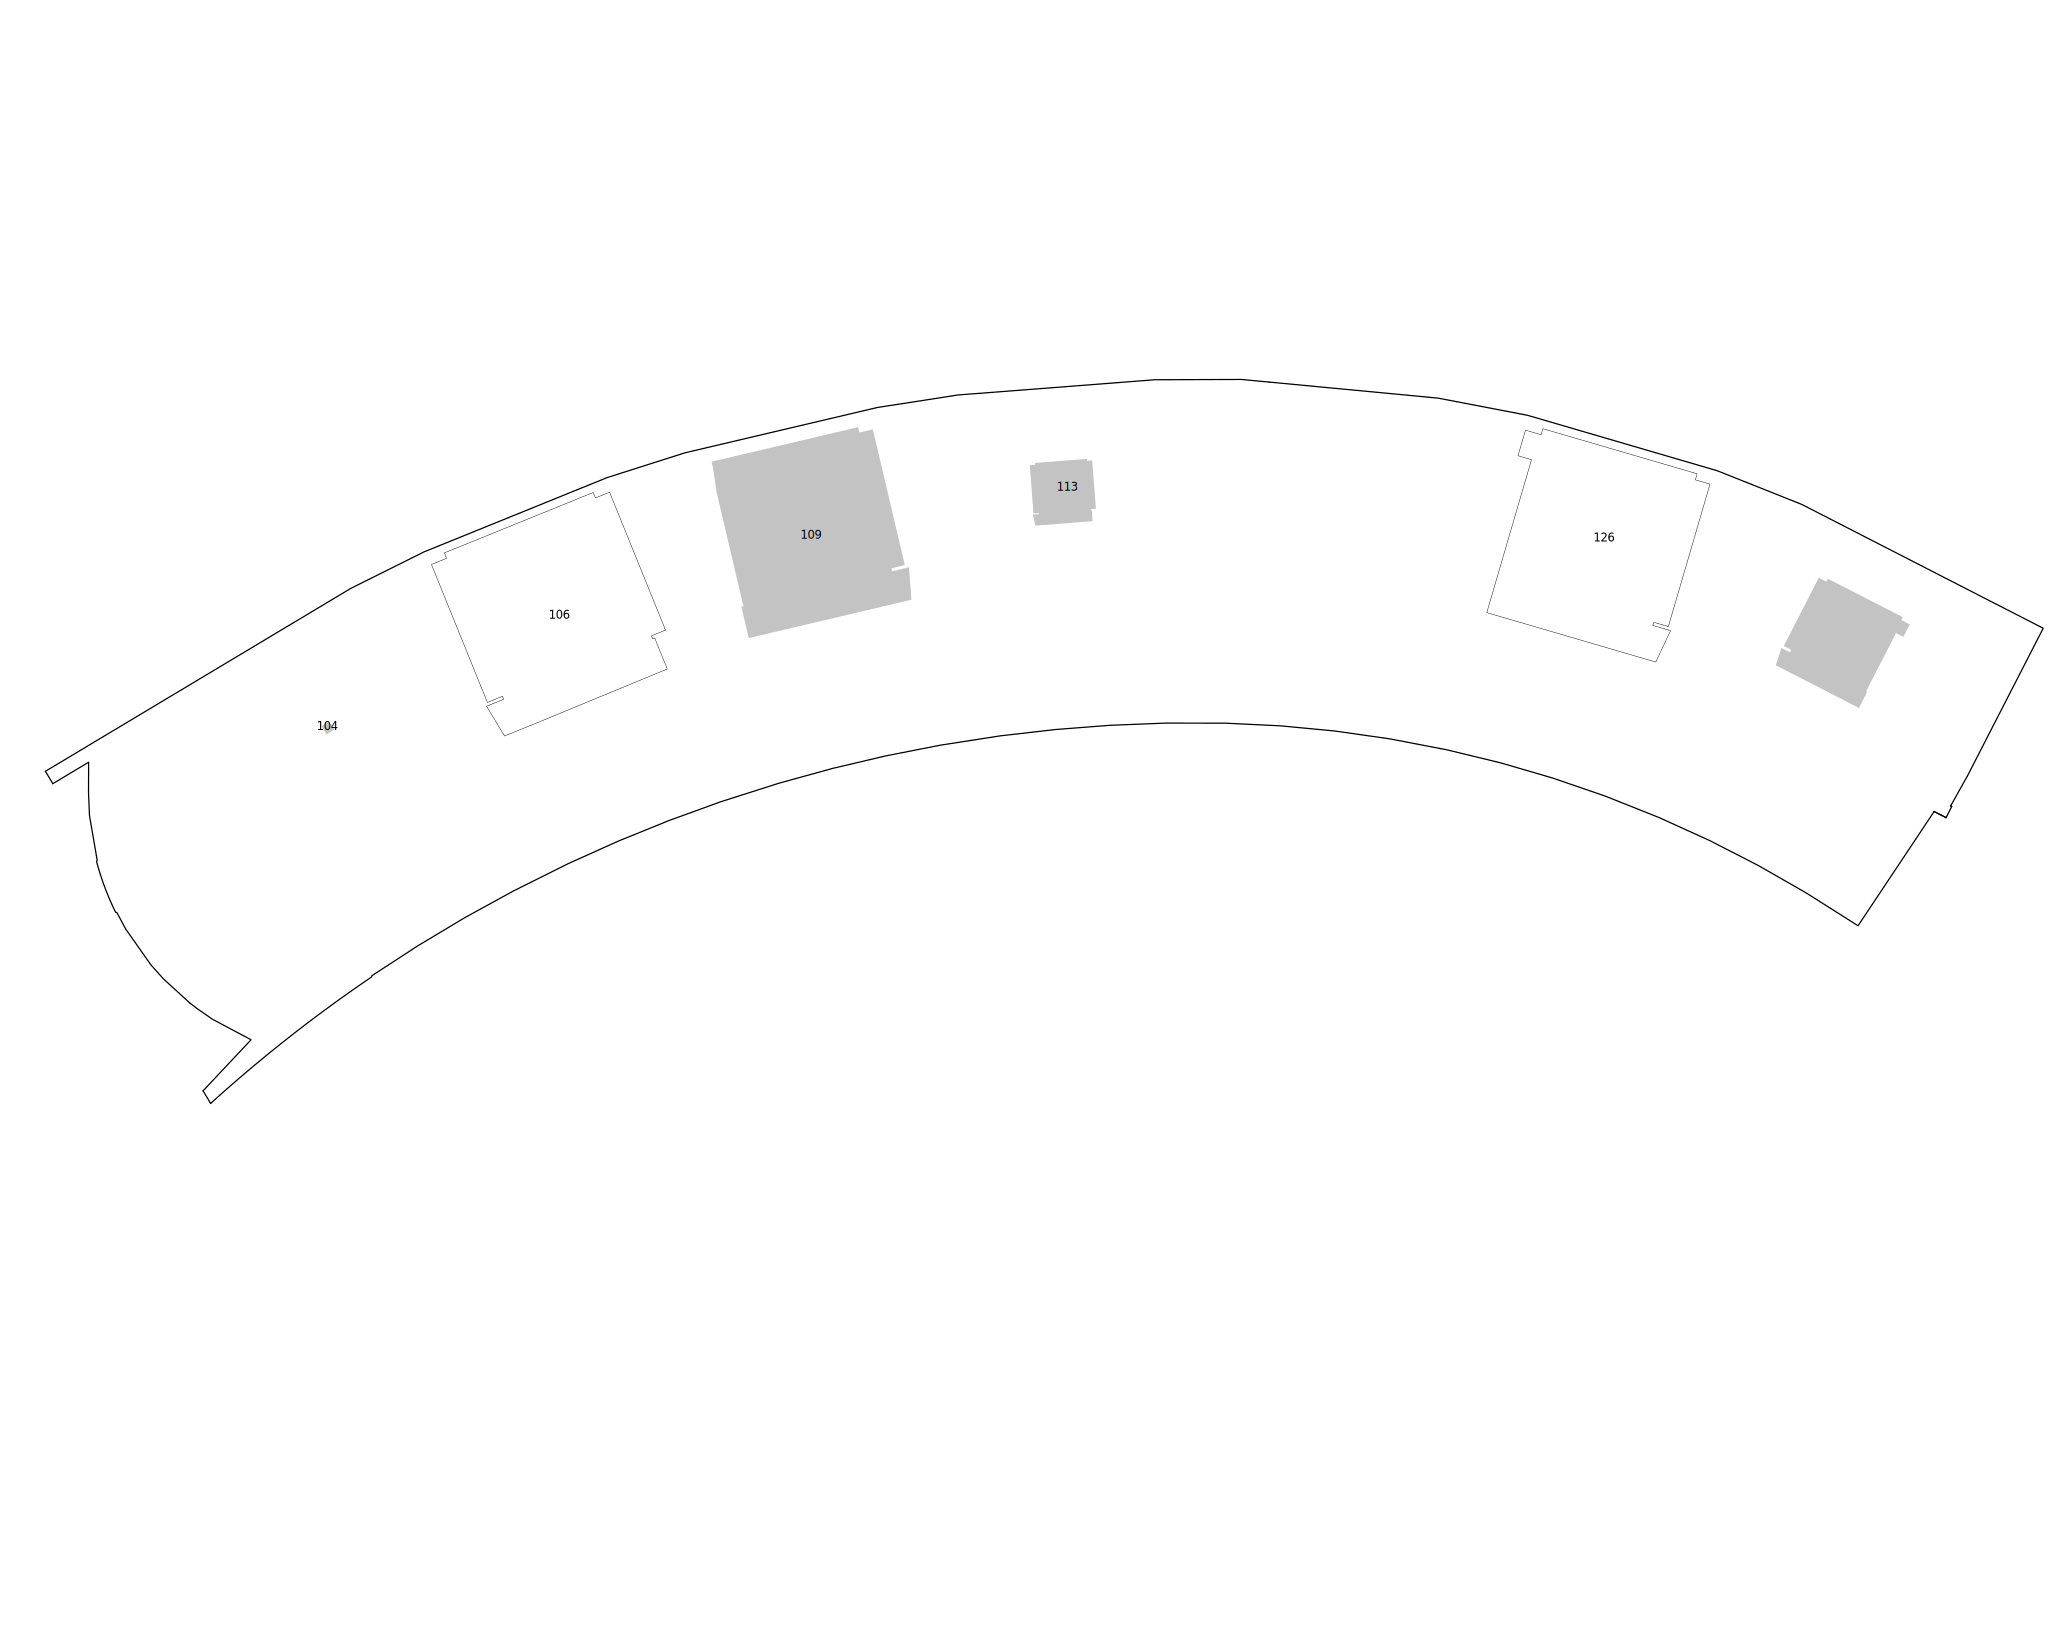

{'104': 0.05, '406': 0.17235294117647054, '209': 0.17235294117647054, '206': 0.17235294117647054, '204': 0.17235294117647054, '304': 0.2947058823529412, '113': 0.3252941176470588, '128': 0.5241176470588235, '428': 0.5700000000000001, '309': 0.6158823529411764, '213': 0.6464705882352942, '306': 0.6464705882352942, '413': 0.6617647058823529, '109': 0.9370588235294117, '326': 1.2429411764705884, '318': 1.6023529411764708, '417': 1.6252941176470588, '328': 2.0}


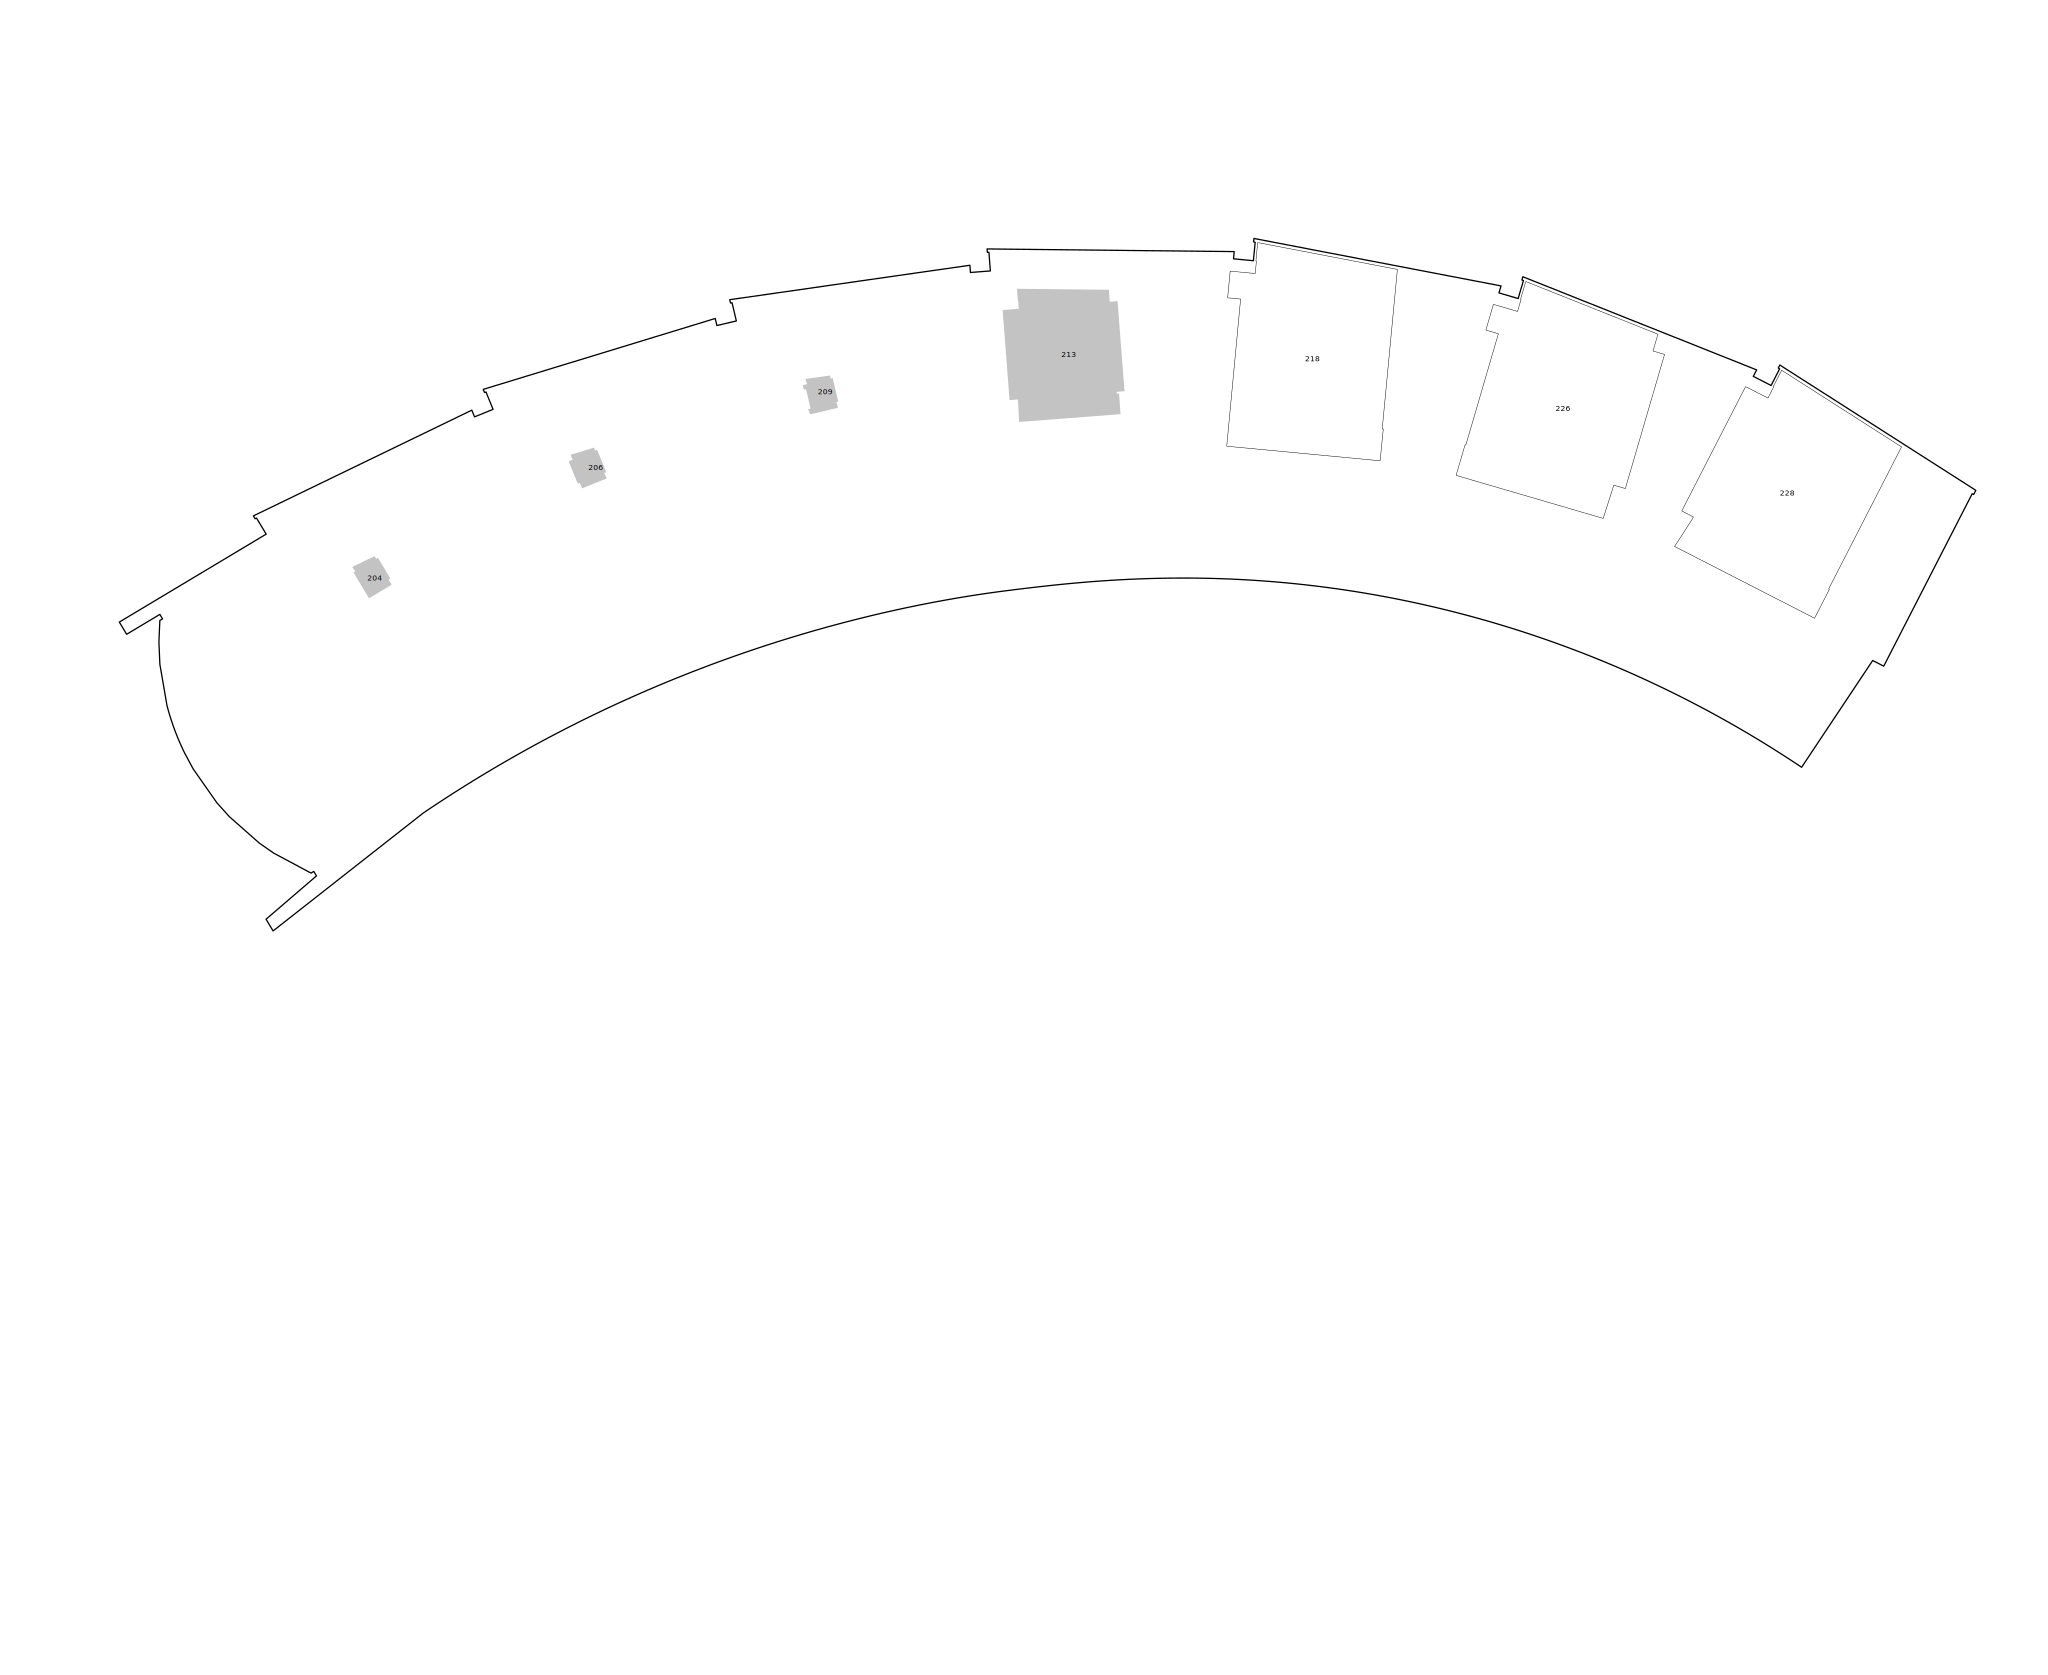

{'104': 0.05, '406': 0.17235294117647054, '209': 0.17235294117647054, '206': 0.17235294117647054, '204': 0.17235294117647054, '304': 0.2947058823529412, '113': 0.3252941176470588, '128': 0.5241176470588235, '428': 0.5700000000000001, '309': 0.6158823529411764, '213': 0.6464705882352942, '306': 0.6464705882352942, '413': 0.6617647058823529, '109': 0.9370588235294117, '326': 1.2429411764705884, '318': 1.6023529411764708, '417': 1.6252941176470588, '328': 2.0}


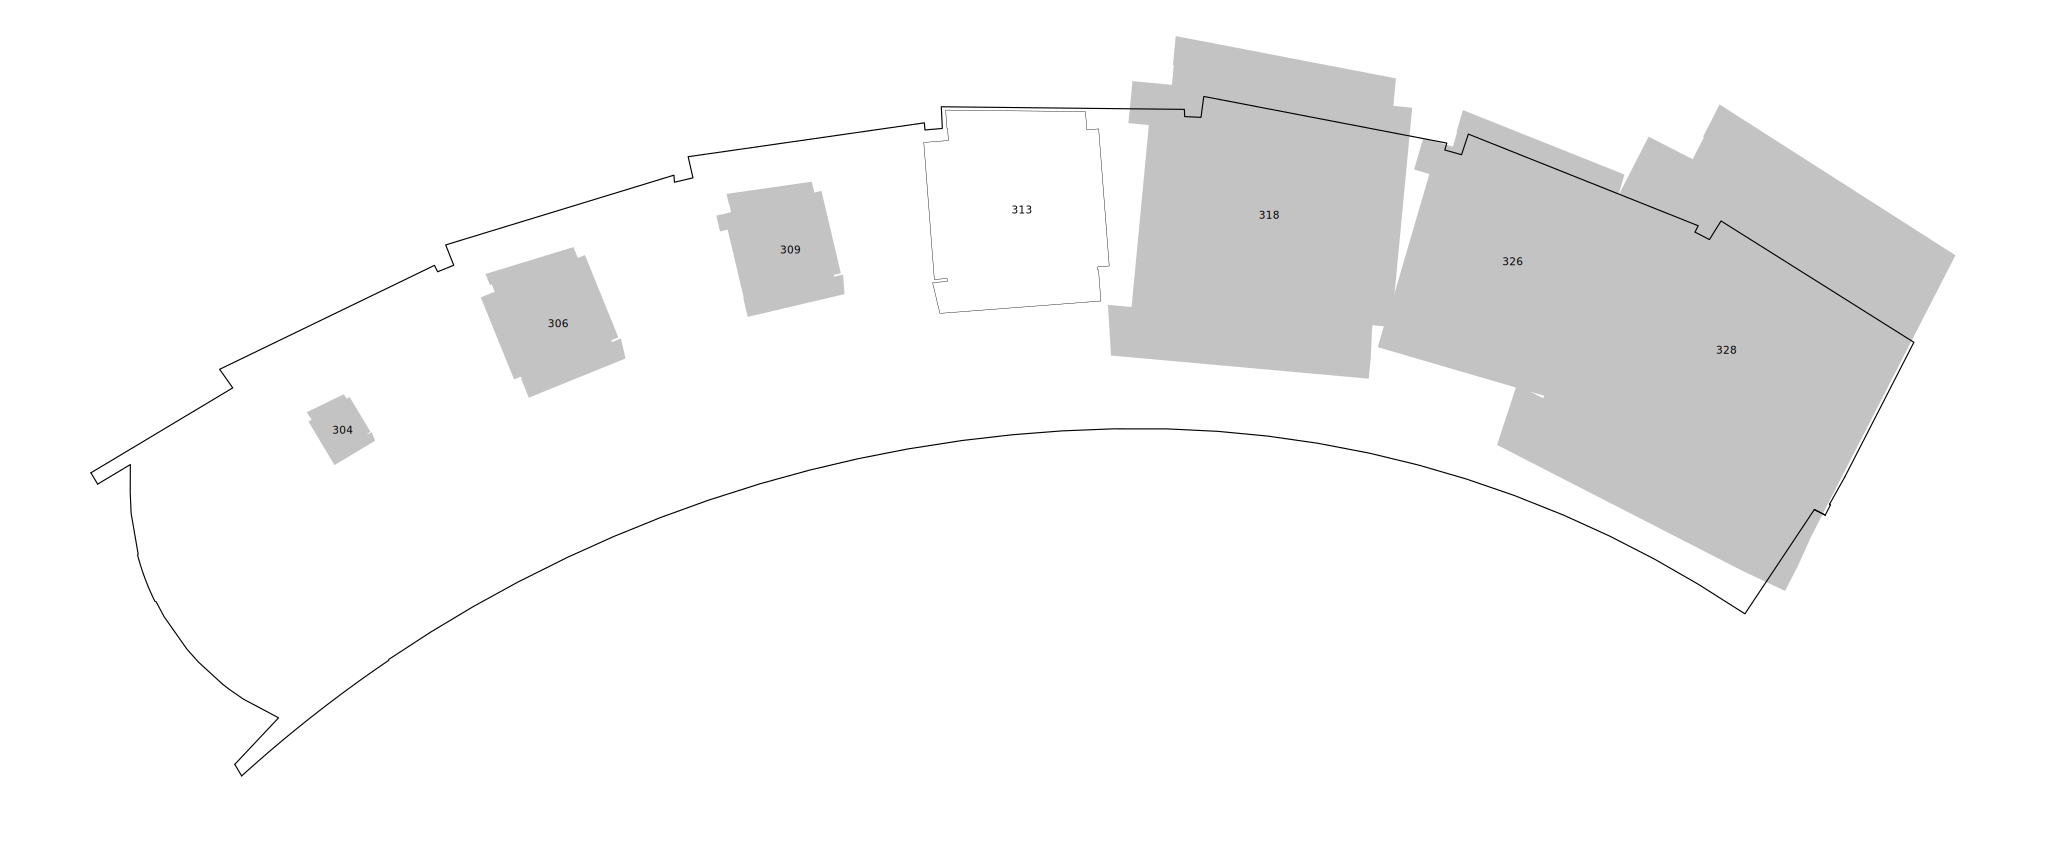

{'104': 0.05, '406': 0.17235294117647054, '209': 0.17235294117647054, '206': 0.17235294117647054, '204': 0.17235294117647054, '304': 0.2947058823529412, '113': 0.3252941176470588, '128': 0.5241176470588235, '428': 0.5700000000000001, '309': 0.6158823529411764, '213': 0.6464705882352942, '306': 0.6464705882352942, '413': 0.6617647058823529, '109': 0.9370588235294117, '326': 1.2429411764705884, '318': 1.6023529411764708, '417': 1.6252941176470588, '328': 2.0}


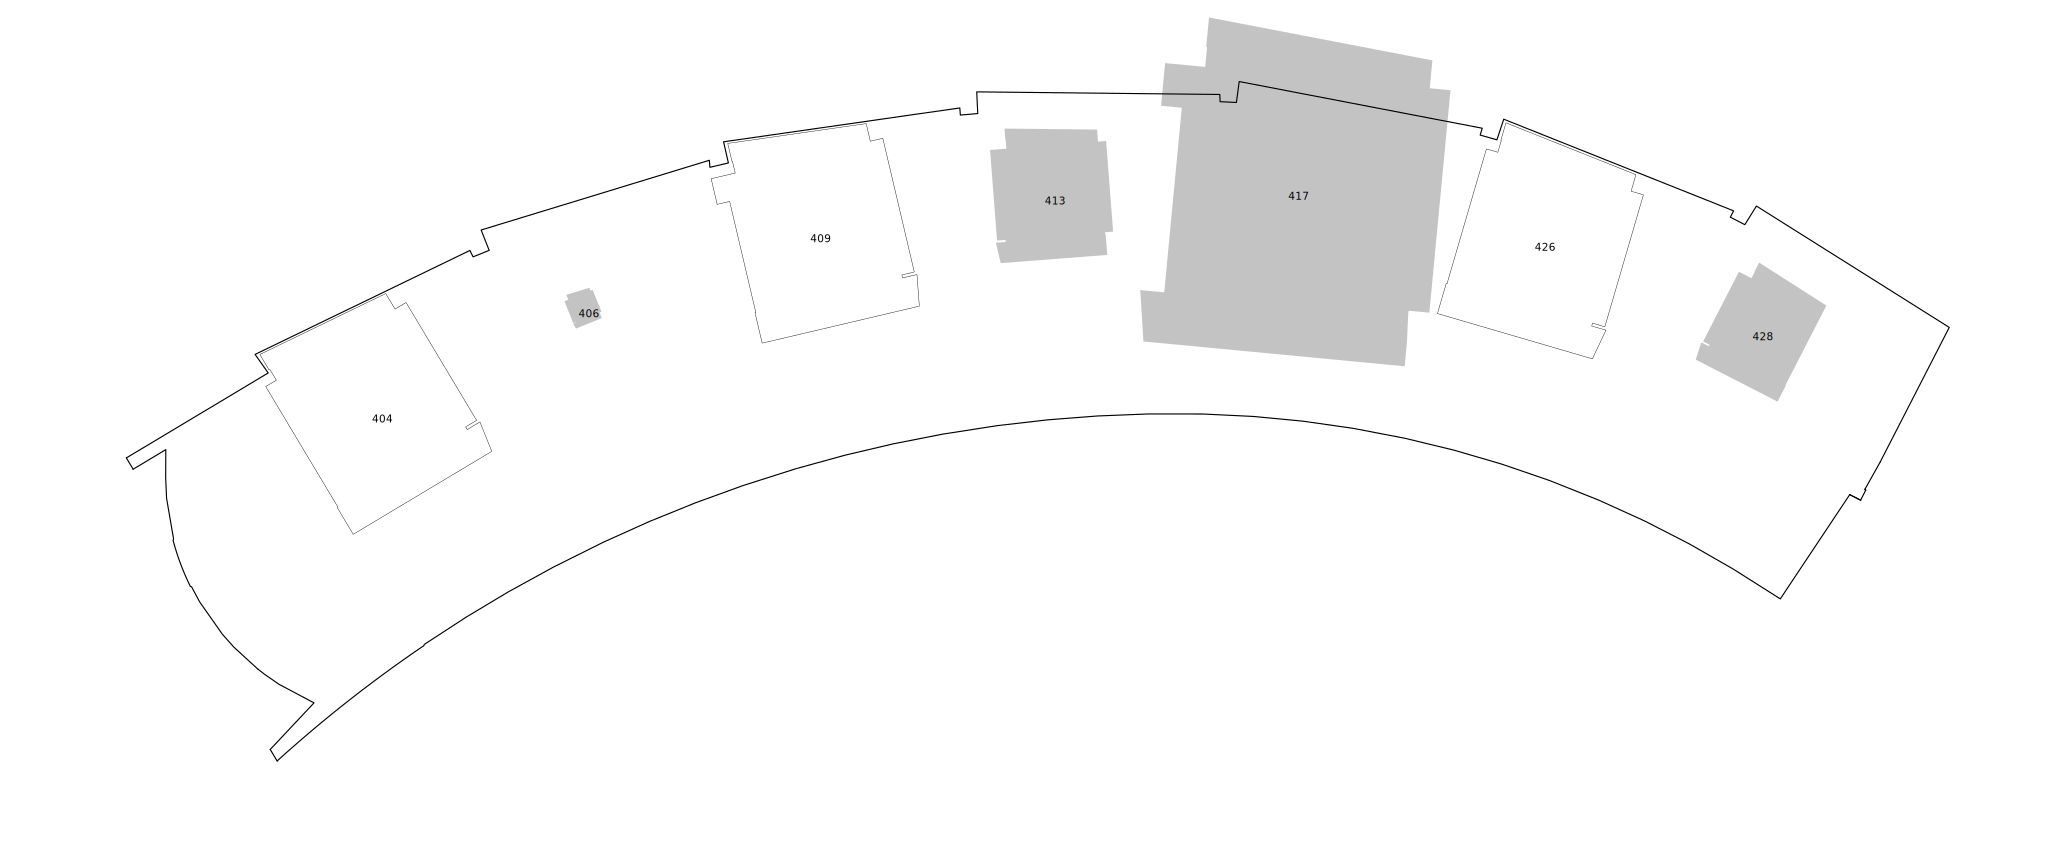

In [399]:
semesters = [('fa17', fa17_room_usage), ('sp18', sp18_room_usage)]

for name, data in semesters:
    for filename in filenames:
        inFile = './' + filename + '.svg'
        outFile = './' + name + '_' + filename +'_util.svg'
        xml = et.parse(inFile)
        ac2 = xml.getroot()
        traces = ac2.findall('.//{http://www.w3.org/2000/svg}g')[0]
        classroom = traces.findall('.//{http://www.w3.org/2000/svg}g')[0]
        utilization = np.transpose(np.array([data['Room'],data['Weekly Length'] / pd.Timedelta(1, unit='h')]))
        utilization[:,1] = rescale(utilization[:,1], 0.05, 2.0)
        utilization = dict(utilization)

        for polygon in classroom.findall('.//{http://www.w3.org/2000/svg}polygon'):
            attrib = dict(polygon.attrib)
            room_no = attrib['id'][-3:]
            try:
                scale = utilization[room_no]
            except KeyError:
                scale = 0.0
            if scale > 0:
                pts = attrib['points']
                pts = np.array(pts.split(' '), dtype=float)
                pts = np.reshape(pts, (-1,2))
                center = getPolygonCenter(pts)
                polygon.set('style', 'fill:#C3C3C3')
                polygon.set('transform', getRecenterString(center, scale) + ' scale(' + str(scale) +')')

        xml.write(outFile)
        display(SVG(filename=outFile))